In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.nn import MessagePassing

# load pickle module
import pickle
import matplotlib.colors as colors
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import matplotlib.pyplot as plt
import scipy.special as SS
import scipy.stats as SSA

In [81]:
class EpidemicSimulator(MessagePassing):
    def __init__(self, r, p, weight, max_time_step, prior_scale=1.):
        super(EpidemicSimulator, self).__init__(aggr='add')
        self.r = r
        self.p_prime = 1-p
        self.max_time_step = max_time_step
        self.Z = 3  # latent period
        self.Zb = 1  # scale parameter for Z
        self.D = 5  # infectious period
        self.Db = 1  # scale parameter for beta
        self.weight = torch.Tensor(weight)
#         print(self.weight)
        self.offspring = []

    def forward(self, x, edge_index, edge_attr, step):
        
        x = self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_attr=edge_attr, step=step)
        return x

    def message(self, x, edge_index, edge_attr, step):
        new_infectors = x[:, 2+step:3+step]  # the infectors at time ti
        population = x[:, 1:2]
        total_infection = torch.sum(x[:, 2:3+step], dim=1, keepdim=True)
        rate = (population - total_infection) / population  # Compute the rate.
        rate[rate < 0] = 0

        new_effective_infectors = new_infectors*rate
        new_infectors_int = new_effective_infectors.round().int()
        
#         temp = new_infectors.round().int()
        cases = new_infectors_int.squeeze().tolist()
        # Initialize an empty tensor to store the results
        results = torch.zeros_like(new_infectors)
        # Generate negative binomial for each size
        for i, size in enumerate(cases):
            #             print(size)
            if size > 0:
                offspring_per_case = torch.distributions.negative_binomial.NegativeBinomial(
                    self.r, self.p_prime).sample(sample_shape=torch.Size([size]))
#                 offspring_per_case = torch.tensor([2]*size)
                # torch.distributions.Categorical(
                #     self.weight).sample(sample_shape=torch.Size([size])) ##cutoff version
#                 self.offspring.extend(offspring_per_case.tolist())
                temp_sum = offspring_per_case.sum()
            else:
                temp_sum = 0
#             print(temp_sum)
            results[i] = temp_sum
        ###### ^^^^^^#######
        # Compute the messages.
        results_aligned = results[edge_index[0]]
        messages = results_aligned * edge_attr.view(-1, 1)
#         bernoulli_dist = torch.distributions.Bernoulli(edge_attr) # Assuming edge_attr is a probability
#         sampled_transmission = bernoulli_dist.sample()

        # Use the sampled values as the messages
#         messages = results_aligned * sampled_transmission.view(-1, 1)
        
        return messages

    
#     def aggregate(self, inputs, index):
    
    
    def update(self, aggr_out, x, step):
        # The new infections are the aggregated messages.
        # aggr_out has shape [N, 1], it contains the updated infections
        new_infections = aggr_out
        #### Add the effective infections to the column corresponding to the current step.####
        # immu first
#         population = x[:, 1:2]
#         total_infection = torch.sum(x[:, 2:3+step], dim=1, keepdim=True)
#         rate = (population - total_infection) / population  # Compute the rate.
#         rate[rate < 0] = 0

#         new_effective_infections = new_infections*rate
        new_infections_int = new_infections.round().int()
        # diffuse the new_infections to different times
        inf_sizes = new_infections_int.squeeze().tolist()
        for i, inf_size_i in enumerate(inf_sizes):
            gamma_dist1 = torch.distributions.Gamma(self.Z, 1/self.Zb)
            gamma_dist2 = torch.distributions.Gamma(self.D, 1/self.Db)
            latency_p = gamma_dist1.rsample(
                sample_shape=torch.Size([inf_size_i]))
            infectious_p = gamma_dist2.rsample(
                sample_shape=torch.Size([inf_size_i]))
            v = torch.rand(inf_size_i)
#             delay_days = torch.tensor([2]*inf_size_i)
            delay_days = latency_p + v * infectious_p #######
#             print(step, delay_days)
            for j, delay_t in enumerate(delay_days):
                t_j = (2+step+delay_t).ceil().int()
                if t_j > self.max_time_step:
                    pass
                else:
                    x[i, t_j] = x[i, t_j] + 1

        return x


def simulate_dynamics(data, R0, r, num_steps):
    p = r/(R0+r)
    xx = np.arange(0, 100, 1)  # define the range of x values the cutoff is 200
#     pmf = SSA.nbinom.pmf(xx, r, p)  # calculate the probability mass function
    pmf = SSA.nbinom.pmf(xx, r.detach().numpy(), p.detach().numpy())
    weights_n = pmf/np.sum(pmf)
#     print(weights_n)
    x = data.x
    T_len = x.shape[1]
    simulator = EpidemicSimulator(r, p, weights_n, max_time_step=(T_len-1))
    for ti in range(num_steps):
        x = simulator(x, data.edge_index, data.edge_attr, ti)
    return x


In [50]:
####small####
# create a graph
A = np.array([[0.25 , 0.25, 0.4, 0.1 ],
        [0.25, 0.75 , 0. , 0. ],
        [0.4, 0. , 0.55 , 0.05],
        [0.1 , 0 , 0.05, 0.85 ]])
# adjacency_matrix = torch.tensor(WN)
adjacency_matrix = torch.tensor(A)
# Get the indices where the adjacency matrix has a non-zero value
edge_index = torch.nonzero(adjacency_matrix, as_tuple=False).t()

# If your adjacency matrix has edge weights, you can get them like this:
edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]
xx = np.zeros((4,62))
xx[:, 1] = np.array([1000]*4)
xx[2,2] = 10
xx = torch.tensor(xx,dtype=torch.float)
data = Data(x=xx, edge_index=edge_index, edge_attr=edge_weight)

XX = simulate_dynamics(
        data, R0=1.5, r=torch.tensor(13.333), num_steps=10)

In [51]:
XX[:,:12]

tensor([[   0., 1000.,    0.,    0.,    8.,    0.,   13.,    0.,   24.,    0.,
           43.,    0.],
        [   0., 1000.,    0.,    0.,    0.,    0.,    4.,    0.,   12.,    0.,
           30.,    0.],
        [   0., 1000.,   10.,    0.,   11.,    0.,   19.,    0.,   31.,    0.,
           51.,    0.],
        [   0., 1000.,    0.,    0.,    1.,    0.,    4.,    0.,   11.,    0.,
           26.,    0.]])

In [ ]:
#### Real####
# NewInf_i, newcases = simulate_dynamics(data, R0=2.5, r=2.0, num_steps=1, edge_index=edge_index)
WN = np.loadtxt('W_avg.csv')
pop = np.loadtxt('pop_new.csv')
T = 60
num_fips = len(pop)
l0 = 1859-1

xx = np.zeros((num_fips, T+2))
xx[:, 1] = pop  # populations
# col_2 is the new infections generated by the new infectors
xx[l0, 2] = 100  # the new infections at time 0 in the seeding location
xx = torch.tensor(xx, dtype=torch.float)

adjacency_matrix = torch.tensor(WN)
# Get the indices where the adjacency matrix has a non-zero value
edge_index = torch.nonzero(adjacency_matrix, as_tuple=False).t()
# If adjacency matrix has edge weights, you can get them like this:
edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]
data = Data(x=xx, edge_index=edge_index, edge_attr=edge_weight)

torch.manual_seed(1)
# XX = simulate_dynamics(
#         data, R0=1.5, r=torch.tensor(13.333), num_steps=60)
XX2 = simulate_dynamics(
        data, R0=5.5, r=torch.tensor(13.333), num_steps=60)

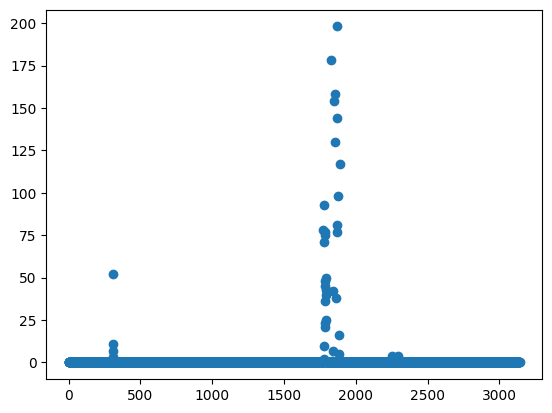

In [83]:
plt.scatter(range(3142),XX[:,-1],label='gnn')

In [68]:
torch.distributions.Bernoulli(torch.tensor([0.1,0.2,0.7]))

Bernoulli(probs: torch.Size([3]))

In [88]:
torch.sum(XX == XX2)

tensor(194804)

In [89]:
XX.shape

torch.Size([3142, 62])

In [90]:
3142*62

194804